# Final Tutorial Notebook
#### Emily Gong, Robert Morrison

In this notebook we will explore the transcripts from UN General Assemblies and the debates therein. Our goal is to understand what differences exist between speakers of different language backgrounds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bs4
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Loading Data
## Raw Data
#### Voting Data

In [159]:
# Notes
resolutions = pd.read_csv("resolutions.csv")

# Notes
# - Germany gets split into East and West (Called German Federal Republic and German Democratic Republic respectively)
# - Modern Germany keeps the name German Federal Republic
states = pd.read_csv("states.csv")

# Notes 
votes = pd.read_csv("votes.csv")

In [103]:
resolutions.head()

,assembly_session,vote_id,resolution,amendment,vote_date,significant_vote,yes_votes,no_votes,abstain,colonization,human_rights,israel_palestine,disarmament,nuclear_weapons,economic_development
0,1,3,R/1/66,1.0,1/1/1946,0,29,18,4,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,R/1/79,0.0,1/2/1946,0,9,34,8,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,R/1/98,0.0,1/4/1946,0,28,22,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1,6,R/1/107,0.0,1/4/1946,0,12,27,10,0.0,1.0,0.0,0.0,0.0,0.0
5,1,8,R/1/297,1.0,1/5/1946,0,38,1,2,0.0,0.0,0.0,0.0,0.0,1.0


In [206]:
resolutions["significant_vote"].sum()

381

In [17]:
states.head()

,year,assembly_session,state_code,state_name,all_votes,yes_votes,no_votes,abstain,idealpoint_estimate,affinityscore_usa,affinityscore_russia,affinityscore_china,affinityscore_india,affinityscore_brazil,affinityscore_israel
0,1946.0,1.0,2,United States of America,42.0,25.0,15.0,2.0,1.7377,1.0,0.2143,NaN,0.4762,0.6429,NaN
1,1947.0,2.0,2,United States of America,38.0,27.0,10.0,1.0,1.8417,1.0,0.2632,NaN,0.2973,0.8421,NaN
2,1948.0,3.0,2,United States of America,103.0,46.0,54.0,3.0,1.9909,1.0,0.1275,NaN,0.3700,0.7767,0.1667
3,1949.0,4.0,2,United States of America,63.0,17.0,33.0,13.0,1.9395,1.0,0.1111,NaN,0.3651,0.5397,0.5161
4,1950.0,5.0,2,United States of America,53.0,26.0,25.0,2.0,1.8651,1.0,0.1731,NaN,0.5094,0.8113,0.6042


In [18]:
votes.head()

,assembly_session,vote_id,resolution,state_code,state_name,member,vote
0,1,3,R/1/66,2,United States of America,1,1
1,1,3,R/1/66,20,Canada,1,3
2,1,3,R/1/66,31,Bahamas,0,9
3,1,3,R/1/66,40,Cuba,1,1
4,1,3,R/1/66,41,Haiti,1,1


In [24]:
states["state_name"].unique()

array(['United States of America', 'Canada', 'Bahamas', 'Cuba', 'Haiti',
       'Dominican Republic', 'Jamaica', 'Trinidad and Tobago', 'Barbados',
       'Dominica', 'Grenada', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Antigua & Barbuda',
       'St. Kitts and Nevis', 'Mexico', 'Belize', 'Guatemala', 'Honduras',
       'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia',
       'Venezuela', 'Guyana', 'Suriname', 'Ecuador', 'Peru', 'Brazil',
       'Bolivia', 'Paraguay', 'Chile', 'Argentina', 'Uruguay',
       'United Kingdom', 'Ireland', 'Netherlands', 'Belgium',
       'Luxembourg', 'France', 'Monaco', 'Liechtenstein', 'Switzerland',
       'Spain', 'Andorra', 'Portugal', 'German Federal Republic',
       'German Democratic Republic', 'Poland', 'Austria', 'Hungary',
       'Czechoslovakia', 'Czech Republic', 'Slovakia', 'Italy',
       'San Marino', 'Malta', 'Albania', 'Montenegro', nan, 'Macedonia',
       'Croatia', 'Yugoslavia', 'Bosnia and Herzegovina', 'S

#### Debate Data

In [2]:
debates = pd.read_csv("un-general-debates.csv")
debates.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [3]:
print(len(debates))

7507


In [4]:
countries = debates["country"].unique()
print(countries)
print(len(countries))

['MDV' 'FIN' 'NER' 'URY' 'ZWE' 'PHL' 'SDN' 'RUS' 'CHN' 'ESP' 'SUR' 'ARG'
 'SLV' 'MYS' 'NPL' 'PRT' 'COL' 'BLR' 'MAR' 'LCA' 'EGY' 'MEX' 'BEL' 'BRN'
 'RWA' 'CAN' 'ALB' 'GRC' 'KNA' 'GUY' 'LBR' 'ATG' 'MOZ' 'JPN' 'YDYE' 'GAB'
 'BGD' 'SWE' 'TUR' 'TCD' 'SYR' 'CMR' 'JAM' 'LUX' 'ITA' 'AGO' 'CRI' 'CSK'
 'BFA' 'MNG' 'BHR' 'HTI' 'OMN' 'CIV' 'TGO' 'CYP' 'MUS' 'MMR' 'ARE' 'GTM'
 'GRD' 'LBY' 'LKA' 'TZA' 'SGP' 'NOR' 'LAO' 'ISL' 'AFG' 'CHL' 'DMA' 'UKR'
 'KEN' 'BLZ' 'FRA' 'MLI' 'VCT' 'VEN' 'MLT' 'GHA' 'GIN' 'GBR' 'ISR' 'YUG'
 'BRB' 'IRQ' 'HUN' 'AUT' 'POL' 'GNB' 'BWA' 'MRT' 'SWZ' 'DNK' 'DOM' 'MDG'
 'NIC' 'BDI' 'CUB' 'IRN' 'PAK' 'SEN' 'BGR' 'YEM' 'STP' 'NLD' 'VUT' 'BOL'
 'PNG' 'SLB' 'DEU' 'ROU' 'KHM' 'TUN' 'BRA' 'IND' 'IDN' 'AUS' 'COD' 'HND'
 'GNQ' 'FJI' 'IRL' 'DZA' 'USA' 'LSO' 'GMB' 'PER' 'DDR' 'THA' 'JOR' 'COG'
 'NGA' 'ECU' 'SAU' 'QAT' 'SYC' 'ETH' 'TTO' 'PRY' 'VNM' 'NZL' 'PAN' 'MWI'
 'DJI' 'BEN' 'SOM' 'ZMB' 'CPV' 'BHS' 'KWT' 'UGA' 'COM' 'ZAF' 'LBN' 'SLE'
 'KOR' 'BIH' 'TON' 'EU' 'HRV' 'NRU' 'TUV' 'NAM' 'S

In [5]:
years = debates["year"].unique()
print(years)
print(len(years))
# 46 Examples of each country

[1989 1970 2013 1985 2008 1991 1986 2002 1975 1996 2012 1997 1978 1988
 2010 1984 1995 2009 1971 1976 1983 1979 1999 2005 1987 1982 1998 2003
 2004 1980 2014 2011 1974 2015 1993 1977 1981 2000 1992 1990 1973 1994
 1972 2006 2007 2001]
46


## Scraping

In [6]:
# Getting a decoding table and access to each countries Wikipedia page
url = "https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3"
r = requests.get(url)
soup = bs4.BeautifulSoup(r.text)

In [7]:
found = soup.find("div", class_="plainlist").find("ul")

In [8]:
lookup = {} # dict {country code : [Country Name, wikipedia link]}

for child in found.children:
    if isinstance(child, bs4.Tag):
        c_code = child.find("span").text
        link = child.find("a").get("href")
        country = child.find("a").text
        
        lookup[c_code] = [country, link]

lookup["CSK"] = ["Czechoslovakia", "/wiki/Czechoslovakia"]
lookup["YDYE"] = ["South Yemen", "/wiki/South_Yemen"]
lookup["YUG"] = ["Yugoslavia", "/wiki/Yugoslavia"]
lookup["DDR"] = ["East Germany", "/wiki/East_Germany"]
lookup["EU"] = ["European Union", "/wiki/European_Union"]

In [9]:
debates["name"] = [lookup[code][0] for code in debates["country"]]

# EDA
### Voting Trends by Country

Here we analyze the voting trends of a few countries over time. We decided to focus on the power players in the UN, which means the United States, Russia, China, Germany, France and Japan .... (**TODO**)

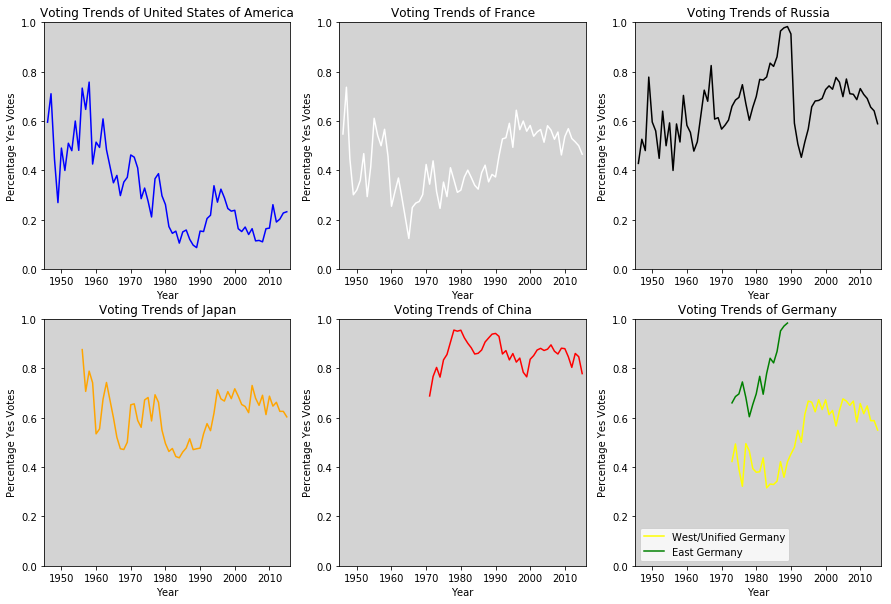

In [86]:
grouped = states.groupby("state_name")

# TODO Clean up code...
power_players = ["United States of America", "France", "Russia", "Japan", "China", "Germany"]
colors = ["blue", "white", "black", "orange", "red", "yellow"]

groups = [(player, grouped.get_group(player)) for player in power_players[:-1]]
groups.append(("Germany", (grouped.get_group("German Federal Republic"), grouped.get_group("German Democratic Republic"))))

fig, axs = plt.subplots(2, 3, figsize=(15,10))
for ax, (name, group), color in zip(axs.ravel(), groups, colors):
    if name != "Germany":
        x = group["year"]
        y = group["yes_votes"] / group["all_votes"]
    else:
        west = group[0].sort_values("year") # Necessary to remove glitch
        east = group[1]
        x = west["year"]
        x1 = east["year"]
        y = west["yes_votes"] / west["all_votes"]
        y1 = east["yes_votes"] / east["all_votes"]
    
    ax.plot(x, y, color=color)
    if name == "Germany": 
        ax.plot(x1, y1, color="green")
        ax.legend(["West/Unified Germany", "East Germany"])
    ax.set_facecolor("lightgray")
    ax.set_title("Voting Trends of "+name)
    ax.set_ylabel("Percentage Yes Votes")
    ax.set_xlabel("Year")
    
    ax.set_ylim(0, 1)
    ax.set_xlim(1945, 2016)
    
plt.show()

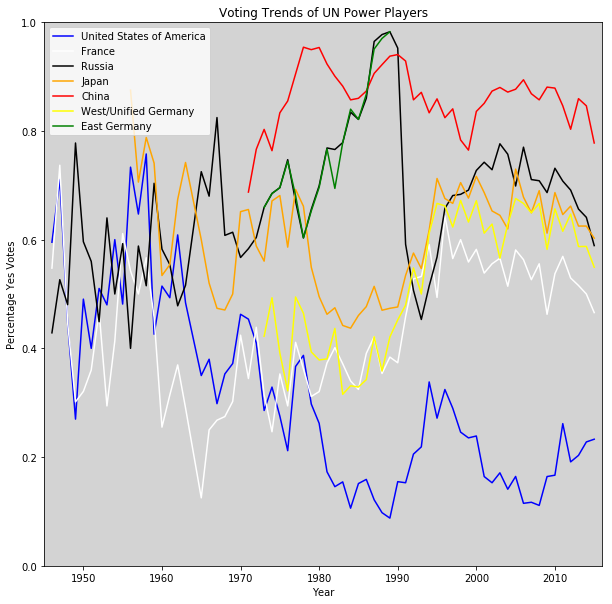

In [97]:
# Same as before, just same plot

grouped = states.groupby("state_name")

# TODO Clean up code...
power_players = ["United States of America", "France", "Russia", "Japan", "China", "Germany"]
colors = ["blue", "white", "black", "orange", "red", "yellow"]

groups = [(player, grouped.get_group(player)) for player in power_players[:-1]]
groups.append(("Germany", (grouped.get_group("German Federal Republic"), grouped.get_group("German Democratic Republic"))))

plt.figure(figsize=(10,10))
for (name, group), color in zip(groups, colors):
    if name != "Germany":
        x = group["year"]
        y = group["yes_votes"] / group["all_votes"]
    else:
        west = group[0].sort_values("year") # Necessary to remove glitch
        east = group[1]
        x = west["year"]
        x1 = east["year"]
        y = west["yes_votes"] / west["all_votes"]
        y1 = east["yes_votes"] / east["all_votes"]
    
    
    if name == "Germany":
        plt.plot(x, y, color=color, label="West/Unified Germany")
        plt.plot(x1, y1, color="green", label="East Germany")
    else:
        plt.plot(x, y, color=color, label=name)

plt.gca().set_facecolor("lightgray")

plt.title("Voting Trends of UN Power Players")
plt.ylabel("Percentage Yes Votes")
plt.xlabel("Year")
plt.legend()
plt.ylim(0, 1)
plt.xlim(1945, 2016)
plt.show()

### Voting Trends on Significant Votes

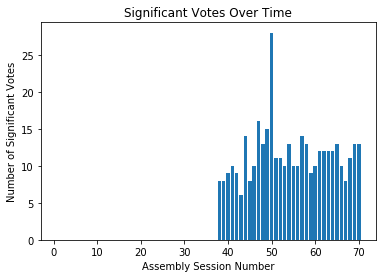

In [222]:
grouped = resolutions.groupby("assembly_session")
x = list(grouped.groups.keys())
y = grouped["significant_vote"].sum().values
plt.bar(x, y)
plt.title("Significant Votes Over Time")
plt.ylabel("Number of Significant Votes")
plt.xlabel("Assembly Session Number")
plt.show()

### Voting Trends by Type

In [202]:
resolution_types = ["colonization","human_rights","israel_palestine","disarmament","nuclear_weapons","economic_development"]
type_dict = {t: i+1 for i, t in enumerate(resolution_types)}
resolution_table = resolutions[["resolution"] + resolution_types]

In [165]:
rs = {}
for i, row in resolution_table.iterrows():
    p = row[row == 1]
    if len(p) > 0:
        rs[row["resolution"]] = p.index[0]
    else:
        rs[row["resolution"]] = "None"
resolutions["type"] = [rs.get(r) or "None" for r in resolutions["resolution"]]
votes["type"] = [rs.get(r) or "None" for r in votes["resolution"]]

type
colonization            954
disarmament             892
economic_development    302
human_rights            803
israel_palestine        859
nuclear_weapons         203
Name: type, dtype: int64


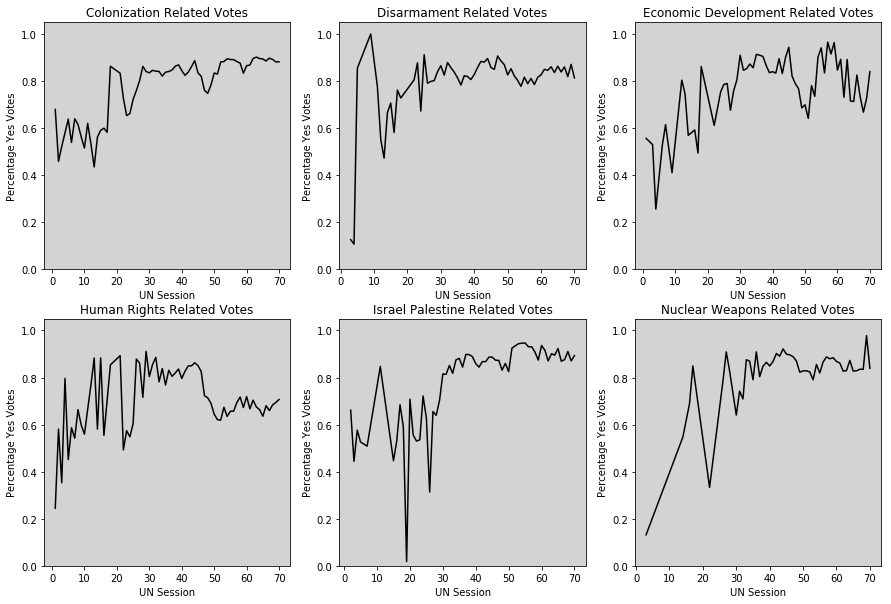

In [204]:
grouped = resolutions[resolutions["type"] != "None"].groupby("type")
print(grouped["type"].count()) # TODO Maybe remove this?

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, (name, group) in zip(axs.ravel(), grouped):
    if name == "None": continue
    group = group.groupby("assembly_session")
    x = group.groups.keys()
    yes = group["yes_votes"].sum()
    no = group["no_votes"].sum()
    abstain = group["abstain"].sum()
    y = yes / (yes + no + abstain)
    
    ax.plot(x,y,color="black")
    ax.set_facecolor("lightgray")
    ax.set_title(name.replace("_", " ").title() + " Related Votes")
    ax.set_ylabel("Percentage Yes Votes")
    ax.set_xlabel("UN Session")
    
    ax.set_ylim(0, 1.05)
    
plt.show()

### Existence of Countries

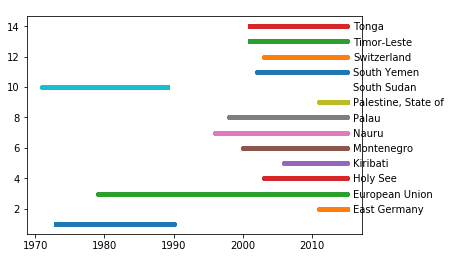

In [10]:
grouped = debates.groupby("name")

# fig, axs = plt.subplots(1, 2, figsize=(17,20))
# plt.subplots_adjust(wspace=.5)

# for ax in axs:
#     ax.yaxis.set_visible(False)
#     ax.margins(x=0.05,y=0.005)
h = 1
for name, group in grouped:
    x = group["year"]
    y = np.empty(len(x))
    y.fill(h)
    
    i = round(h / len(grouped))
    #ax = axs[i]
    if len(x) < 20:
        h += 1
        plt.plot(x, y, linewidth=5)
        plt.annotate(name, xy=(2016,h-0.25))
    
plt.show()

### Word Counts

In [11]:
count_vect = CountVectorizer(max_df=.90, min_df=2, max_features=1000)
tfidf_vect = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000)

counts = count_vect.fit_transform(debates["text"][:100])
count_total = np.array(counts.sum(axis=0))[0]
count_vocab = count_vect.vocabulary_
count_feats = np.array(count_vect.get_feature_names())

tfidfs = tfidf_vect.fit_transform(debates["text"][:100])
tfidf_vocab = tfidf_vect.vocabulary_
tfidf_feats = np.array(count_vect.get_feature_names())

In [12]:
max_indices = np.array(tfidfs.argmax(axis=1).T)[0]
max_words = tfidf_feats[max_indices]

In [13]:
important_counts = np.empty((0,2))
for doc, word in enumerate(max_words):
    index = count_vocab[word]
    count = counts[doc,index]
    important_counts = np.append(important_counts, np.array([[word, count]]), axis=0)
important_counts = pd.DataFrame(important_counts, columns=["word", "count"])

In [14]:
# Word counts of the most important words in each document...
important_counts.head()

,word,count
0,small,9
1,keeping,10
2,african,11
3,democracy,9
4,african,17
